# Самостоятельный проект. Основы ML

# Исследование оттока клиентов сети фитнес-клубов

**Описание, цели и задачи исследования:**

Для разрабатки стратегии взаимодействия с клиентами сети фитнес-центров «Культурист-датасаентист» необходимо провести анализ анкет клиентов  сети, в т.ч.
- спрогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;
- сформировать типичные портреты клиентов: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;
- проанализировать основные признаки, наиболее сильно влияющие на отток;
- сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:

1) выделить целевые группы клиентов;

2) предложить меры по снижению оттока;

3) определить другие особенности взаимодействия с клиентами.

## Загрузка данных

In [1]:
#импорт библиотек
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import time
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import silhouette_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve

In [2]:
#загрузка файлов в датафрейм
try:
    clients = pd.read_csv('/datasets/gym_churn.csv')
except:
    clients = pd.read_csv('https:/??????????????/datasets/gym_churn.csv')

In [3]:
#проверим корректность загрузки
#display(clients.info())
#display(clients.head())

**Предварительный вывод:**

Данные загружены корректно. Часть атрибутов имеют тип int64, при этом явно являются категориальными признаками - *gender*: [1,0] = [m, f] или наоборот, *Near_Location, Partner, Promo_friends, Phone, Group_visits, Churn*: скорее всего [1,0] = [yes, no] и врядли наоборот. Т.к. не сказано обратное, то будетм считать, что 1 = да, 0 = нет. *Contact_period* -  категориальный признак (1, 6, 12 месяцев, как сказано в описании)

Как было видно выше, при проверке корректности загрузки, пропущенных значений в датасете нет. Каждый атрибут содержит 4000 непустых записи. Дополнительную предобработку проводит не требуется. Изменим написание наименований атрибутов для удобства.

In [4]:
print('Пропущенных значений:', clients.isna().sum())

Пропущенных значений: gender                               0
Near_Location                        0
Partner                              0
Promo_friends                        0
Phone                                0
Contract_period                      0
Group_visits                         0
Age                                  0
Avg_additional_charges_total         0
Month_to_end_contract                0
Lifetime                             0
Avg_class_frequency_total            0
Avg_class_frequency_current_month    0
Churn                                0
dtype: int64


In [5]:
print('Явных дубликатов:', clients.duplicated().sum())

Явных дубликатов: 0


In [6]:
clients.columns = clients.columns.str.lower()

Также можно сгруппировать атрибуты в датафрейме: сначала категориальные, потом возраст, контракт, временные характеристики, деньги

In [7]:
clients.columns.tolist()

['gender',
 'near_location',
 'partner',
 'promo_friends',
 'phone',
 'contract_period',
 'group_visits',
 'age',
 'avg_additional_charges_total',
 'month_to_end_contract',
 'lifetime',
 'avg_class_frequency_total',
 'avg_class_frequency_current_month',
 'churn']

In [8]:
#сохраним список исключительно количественных переменных
qua_param_list = ['age', 'avg_class_frequency_total',  'avg_class_frequency_current_month', 'avg_additional_charges_total']

In [9]:
#пересоберем датафрейм
clients = clients[['gender',
                    'near_location',
                    'partner',
                    'promo_friends',
                    'phone',
                    'group_visits',
                    'churn',
                    'age',
                    'contract_period',
                    'month_to_end_contract',
                    'lifetime',
                    'avg_class_frequency_total',
                    'avg_class_frequency_current_month',
                    'avg_additional_charges_total']]

## Исследовательский анализ данных (EDA)

### Описательная статистика

In [10]:
clients.describe()

,gender,near_location,partner,promo_friends,phone,group_visits,churn,age,contract_period,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,avg_additional_charges_total
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,0.412250,0.265250,29.184250,4.681250,4.322750,3.724750,1.879020,1.767052,146.943728
std,0.499957,0.361711,0.499887,0.461932,0.295313,0.492301,0.441521,3.258367,4.549706,4.191297,3.749267,0.972245,1.052906,96.355602
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.148205
25%,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,27.000000,1.000000,1.000000,1.000000,1.180875,0.963003,68.868830
50%,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,29.000000,1.000000,1.000000,3.000000,1.832768,1.719574,136.220159
75%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,31.000000,6.000000,6.000000,5.000000,2.536078,2.510336,210.949625
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,41.000000,12.000000,12.000000,31.000000,6.023668,6.146783,552.590740


Т.о (для категориальных признаков среднее значение также является долей клиентов, для которых значение признака равно "да"):
- по признакам "пол" и "клиент-сотрудник компании-партнера" разделение примерно одинаковое
- по признаку "проживания или работы рядом с центром" 84,5% клиентов проживают или работают рядом
- 30,8% клиентов при оплате первого абонемента использовали промо-код в рамках кампании "приведи друга";
- подавляющее большинство клиентов указали в анкете свой номер телефона (90%);
- 41% посещают групповые занятия;
- средний возраст - 29,2 лет и таких клиентов больше половины (медиана также равна ровно 29)
- более половины клиентов купили абонементы на месяц
- в среднем анализируются анкеты клиентов, кто ходит в центр 3,7 месяцев
- в среднем клиенты ходят в центр 1,87 раза в неделю, что не сильно отличается от среднего количества посещений за последний месяц - 1,77
- 146 у.е. в среднем составляет суммарная выручка от других услуг центра 
- и самое печальное, что все-таки 26% клиентов "утекут" в следующем месяце (практически 1000 клиентов из 4000)

Полученные значения стандартного отклонения в целом достаточно объяснимы. Для большинства категориальных переменных  значение сигма примерно 0,5. Если учесть что среднее значение между 0 и 1 также 0,5, то и понятно почему такая сигма.

Возможно могут возникнуть сомнения по поводу значений стандартного отклонения для атрибутов *month_to_end_contract, lifetime, avg_class_frequency_total,	avg_class_frequency_current_month*.
- *month_to_end_contract* среднее 4,33, сигма 4,19 говорит о том, что у практически половины клинетов скоро завершится контракт, т.к. разность между средней и сигмой стермится к 0.
- *lifitime* среднее 3,72, сигма 3,74 говорят нам о том, что больше половины клиентов заполнили анкету во время получения абонемента
- *avg_class_frequency_total и avg_class_frequency_current_month* сигма - половина от среднего. Т.к. среднее меньше 2, то такие значения могут свидетельствовать о том, что многие клиенты посещают центр менее 1 раза в неделю или не посещают во все за длительный промежуток времени

Подтвердить данные предположения можно посмотрев на гистограммы распределения признаков. На них мы увидим, что распределение количественных признаков в целом нормальное, есть ряд "выбросов" для количества посещений центра - большое кол-во клинетов, кто не посещает центры (значение параметров = 0)

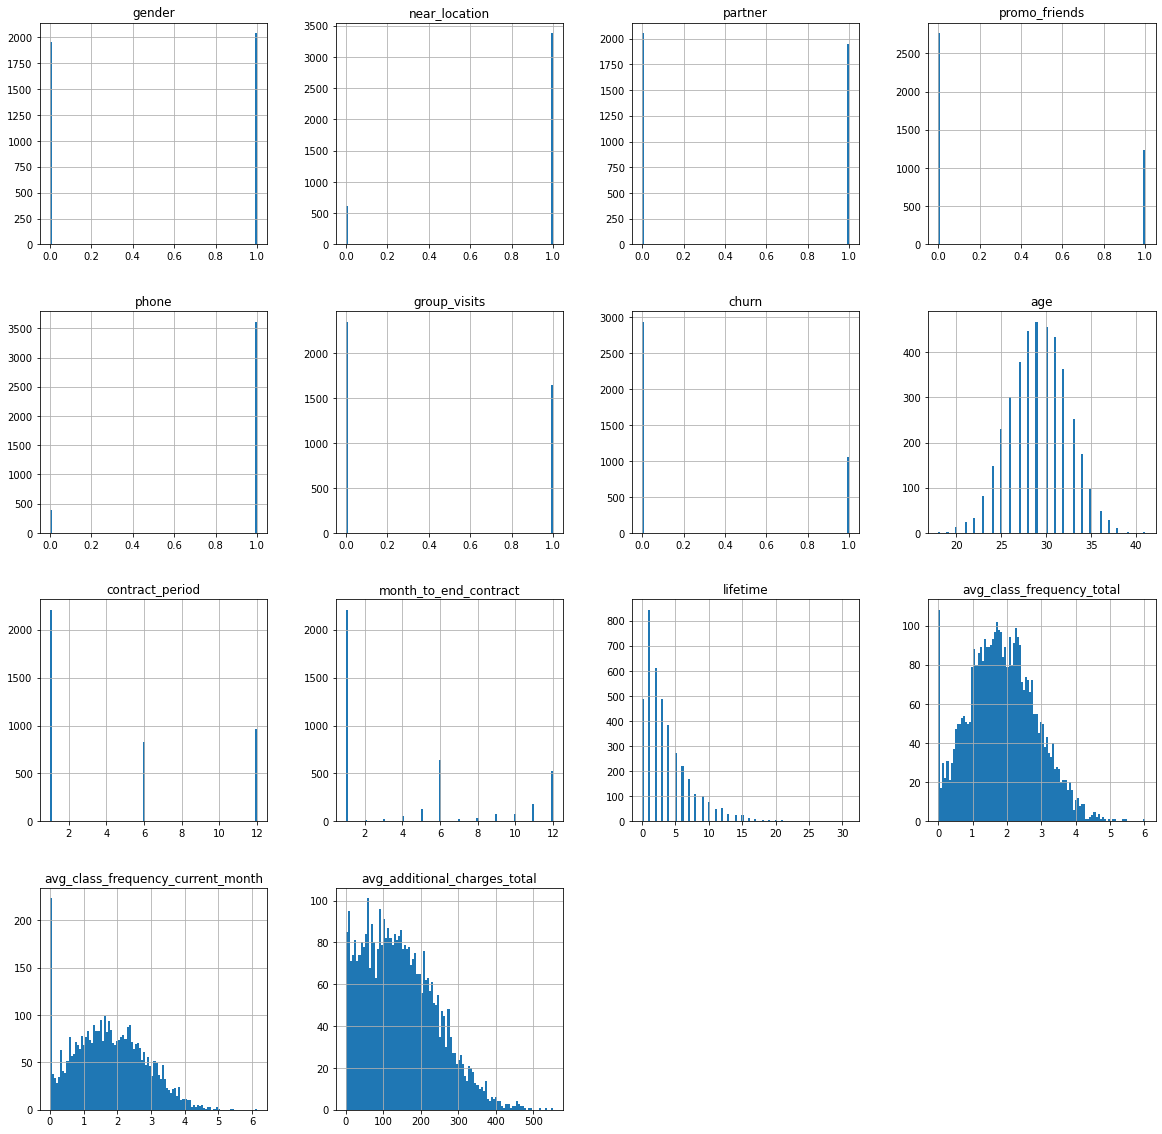

In [11]:
clients.hist(bins=100, figsize=(20,20))
plt.show()

### Средние по группам

Проверим средние значения признаков для 2-х групп клинетов:
- 0 - те, кто останется клиентом
- 1 - те, кто перестанет посещать фитнес-залы
Напомню, что для категориальных признаков значения средних это в т.ч. доля пользователей

In [12]:
churn_group_mean = clients.groupby(['churn']).mean().T
churn_group_mean = churn_group_mean.rename(columns={0: 'stay', 1: 'flow'})
churn_group_mean['Δ'] = churn_group_mean['stay'] - churn_group_mean['flow']
churn_group_mean

churn,stay,flow,Δ
gender,0.510037,0.510839,-0.000801
near_location,0.873086,0.768143,0.104943
partner,0.534195,0.355325,0.178870
promo_friends,0.353522,0.183789,0.169733
phone,0.903709,0.902922,0.000787
group_visits,0.464103,0.268615,0.195489
age,29.976523,26.989632,2.986890
contract_period,5.747193,1.728558,4.018635
month_to_end_contract,5.283089,1.662582,3.620507
lifetime,4.711807,0.990575,3.721232


В соответствии с полученным распеределнием можно заключить, что пол, наличие телефона, близость к фитнес-центру практически не влияет на отток клиентов, т.к. в двух группах клиентов (кто останетсяя и кто уйдет) занчения средних для этих параметров близки.

С другой стороны, среди тех кто останется (остается посещать фитнес-зал) **выше доля** клиентов, кто пришел в рамках акции "приведи друга", кто посещает групповые занятия, также для них характерно более длительное и частое посещение центра, наличие  более длительных абонементов. Также их возраст в срденем на 3 года больше, чем тех, кто уйдет в следующем месяце

### Графики распределений

1) Рассмотрим диаграммы попарных распределений в разрезе оттока. 

Визуализация будет не очень наглядной, т.к. всего возможных вариантов попарных распеределний - (14-1)^2 = 169. Часть диаграмм будут представлять из себя 4 точки - возможные варианты перебора значений 0 и 1 для всех категориальных переменных. 

Целесообразнее будет представить распределение в виде распределения плотности переменных в разрезе оттока

In [13]:
#Пример полного попарного распределения
#sns.pairplot(clients, hue='churn')

<Figure size 1152x1152 with 0 Axes>

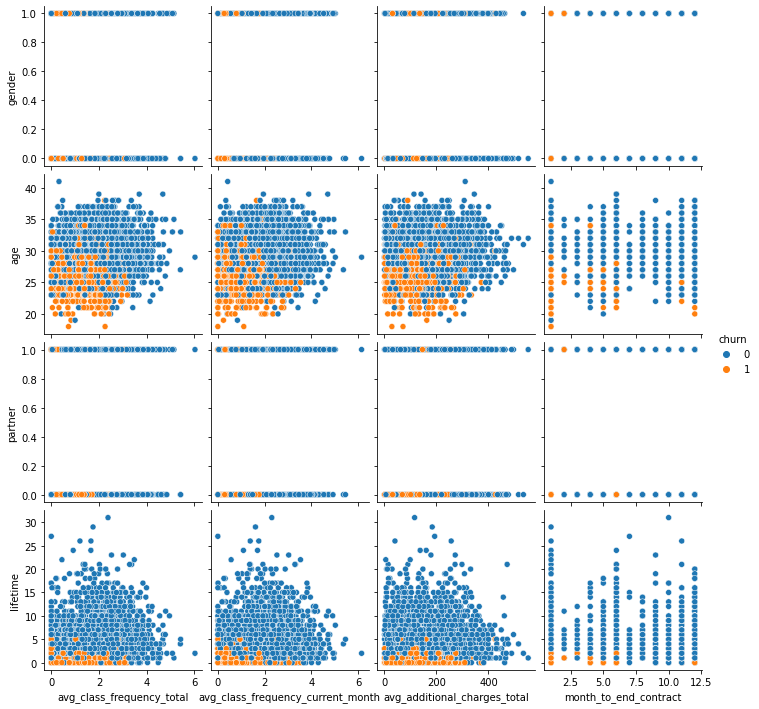

In [14]:
#пример попарного распределения
plt.figure(figsize=(16,16))
sns.pairplot(clients, x_vars=['avg_class_frequency_total', 
                              'avg_class_frequency_current_month', 
                              'avg_additional_charges_total',
                              'month_to_end_contract'], 
                      y_vars=['gender', 'age', 'partner', 'lifetime'], hue='churn')
plt.show()

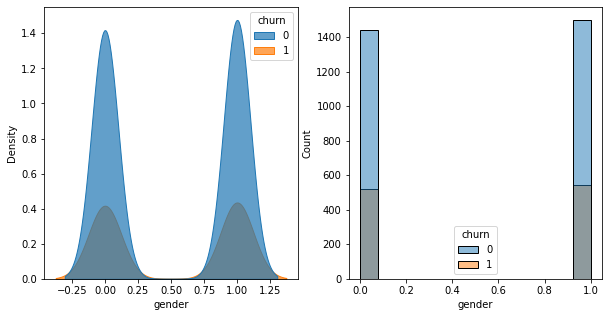

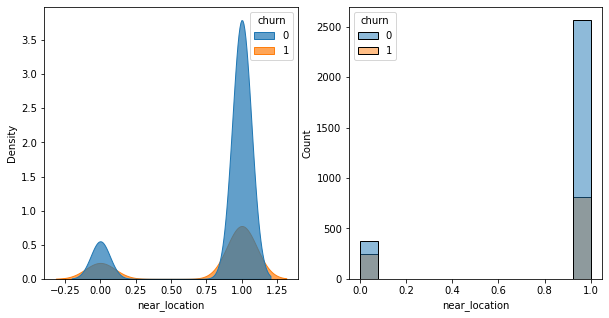

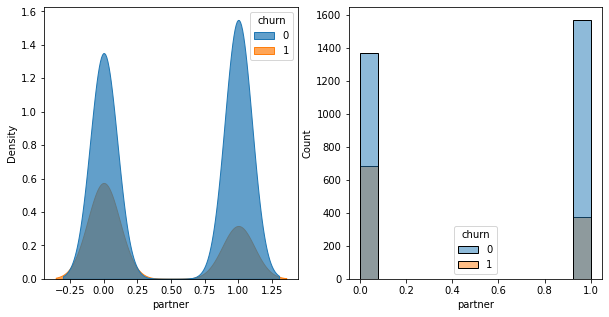

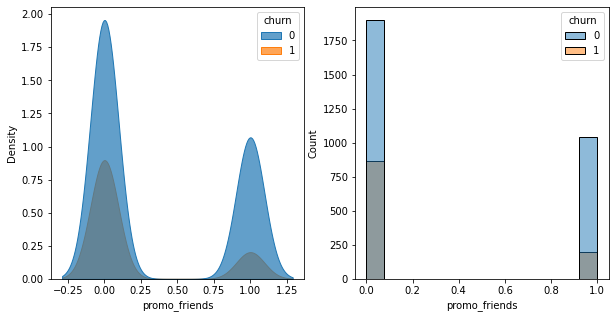

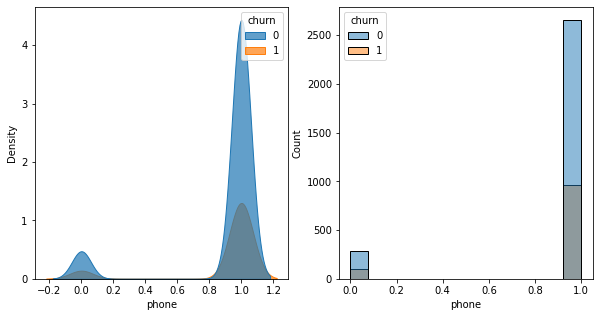

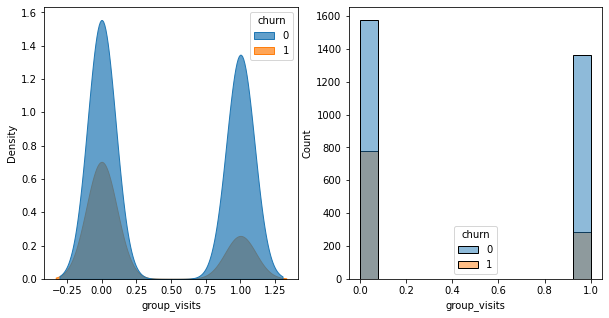

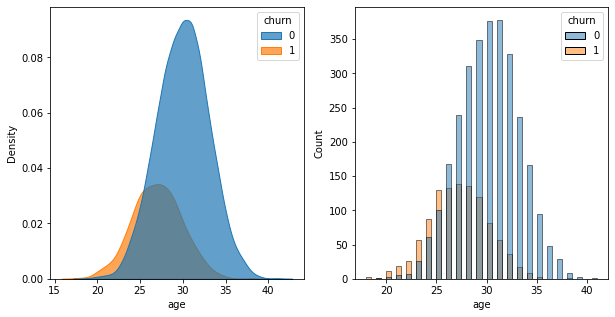

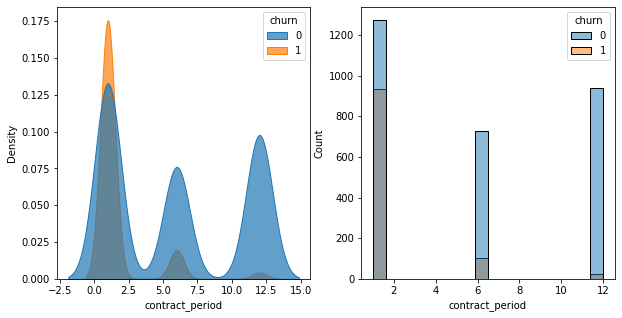

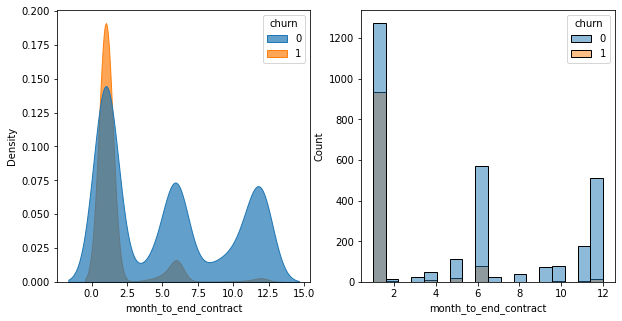

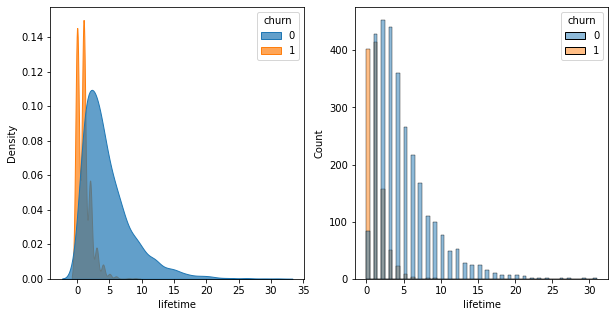

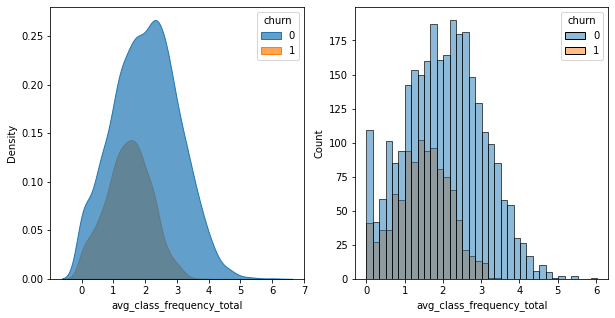

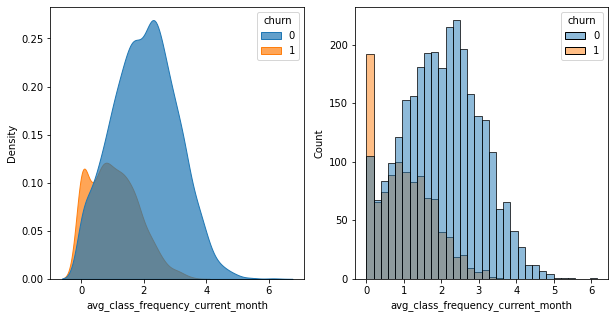

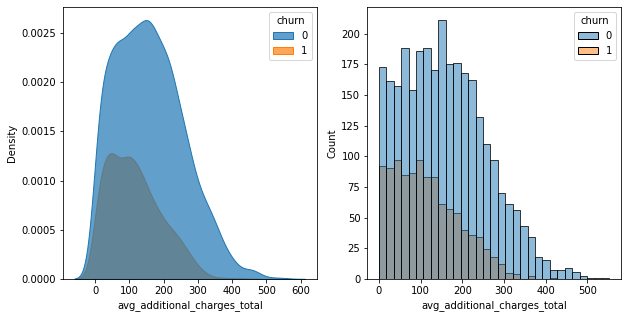

In [15]:
for feature in clients.drop(['churn'], axis=1).columns:
    fig, ax = plt.subplots(figsize = (10, 5))
    sns.kdeplot(data=clients, x=feature, hue='churn', fill=True, alpha=0.7, ax = plt.subplot(1,2,1))
    sns.histplot(data=clients, x=feature, hue= 'churn', ax = plt.subplot(1,2,2))
    plt.show()

В целом, каких-то новых полезных сведений о распеределении клиентов, зависимости "вероятности" оттока от других параметров из данных диаграмм получить не представляется возможным, но все-таки опишем полученный результат:
- пол не зависит на отток, в обоих группах примерно одинаковая доля мужчин и женщин
- возможно, что удаленность до центра влияет на вероятность оттока. Среди тех, кто не будет посещать фитнес-центр больше тех, кто живет и работает не  в районе нахождения центра
- работа в компании партнере с верятностью 50на50 влияет на отток, при этом количество клиентов, кто работает в компании-партнете и не будет пользоваться услугами существенно ниже
- количество ушедших в возрасте менее 25 лет незначительно больше, чем тех кто останется
- вероятность уйти (и не накачать бицуху) выше у тех, кто купил абонемент на 1 месяц
- аналогично вероятность уйти выше у тех, у кого до конца срока действия абонемента осталось 1 и менее месяцев
- предыдущих 2 пунка также подверждают тот факт, что вероятность (и количество клиентов) уйти выше у тех, у кого время с момента первого обращения в фитнес-центр 1 месяц и меньше
- количество посещений фитнес-центра в месяц ниже у тех, кто решится уйти, также у них ниже расходы
- те клиенты, которые практически не ходят в зал (кол-во посещений в неделю ~ 0 и менее 1) основные претенденты на отток

### Корреляции

Построим матрицы корреляций в табличном и графическом виде. Маркетинговому отделу возможно будет полезно иметь таблицу и картинку отдельно

In [16]:
clients.corr().style.format("{:.2f}").background_gradient(cmap='Reds', axis=0)

,gender,near_location,partner,promo_friends,phone,group_visits,churn,age,contract_period,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,avg_additional_charges_total
gender,1.00,0.01,-0.01,-0.01,-0.01,0.02,0.00,0.01,0.00,-0.00,0.01,0.01,0.01,-0.01
near_location,0.01,1.00,-0.01,0.21,-0.02,0.15,-0.13,0.06,0.15,0.14,0.07,0.04,0.06,0.04
partner,-0.01,-0.01,1.00,0.45,0.01,0.02,-0.16,0.05,0.31,0.29,0.06,0.02,0.05,0.02
promo_friends,-0.01,0.21,0.45,1.00,0.00,0.12,-0.16,0.05,0.24,0.24,0.07,0.03,0.05,0.04
phone,-0.01,-0.02,0.01,0.00,1.00,-0.01,-0.00,-0.01,-0.01,-0.01,-0.02,0.01,0.01,0.01
group_visits,0.02,0.15,0.02,0.12,-0.01,1.00,-0.18,0.08,0.17,0.16,0.08,0.06,0.08,0.03
churn,0.00,-0.13,-0.16,-0.16,-0.00,-0.18,1.00,-0.40,-0.39,-0.38,-0.44,-0.25,-0.41,-0.20
age,0.01,0.06,0.05,0.05,-0.01,0.08,-0.40,1.00,0.14,0.13,0.16,0.12,0.18,0.08
contract_period,0.00,0.15,0.31,0.24,-0.01,0.17,-0.39,0.14,1.00,0.97,0.17,0.10,0.16,0.11
month_to_end_contract,-0.00,0.14,0.29,0.24,-0.01,0.16,-0.38,0.13,0.97,1.00,0.16,0.09,0.15,0.11


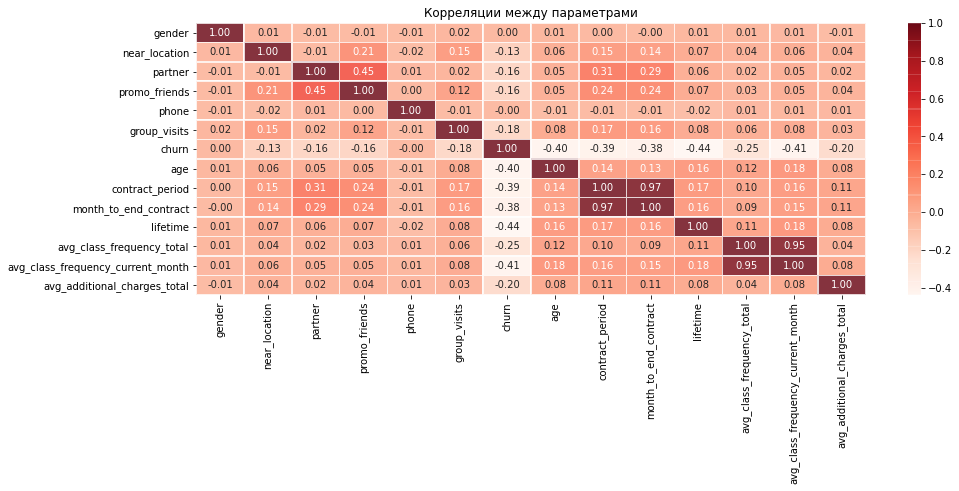

In [17]:
plt.figure(figsize=(15,5))
sns.heatmap(data=clients.corr(), annot=True, linewidths=0.5, fmt = '0.2f', alpha=0.8, cmap='Reds')
plt.title('Корреляции между параметрами')
plt.show()

Как видно из матрицы корреляций, особых взаимосвязей между "независимыми" переменными нет. Наюблюадется очень слабая корреляция практически между всеми переменными. Сильная зависимость между длительностью абонемента и "остатком" времени на абонементе, а также между количество посещений в неделю в целом и за последний месяц. Ничего необычного в такой сильной зависимости нет. Данные признаки мультиколлинеарны. Возможно целесообразно из данных параметров создать новый параметр. Т.о. понизим размерность 

Совершенно отстуствует корреляция между оттоком и возрастом, оттоком и наличием телефона. 

Рассмотрим отдельно группы ушедших и остающихся

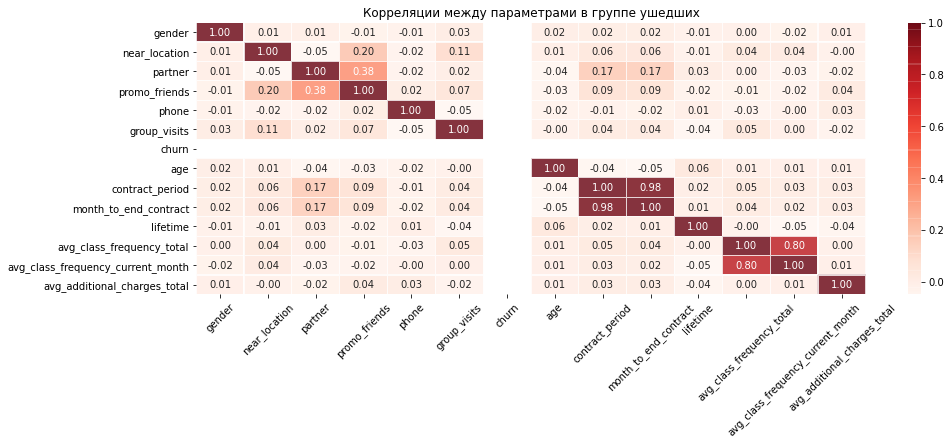

In [18]:
plt.figure(figsize=(15,5))
sns.heatmap(data=clients.query('churn == 1').corr(), annot=True, linewidths=0.1, fmt = '0.2f', alpha=0.8, cmap='Reds')
plt.title('Корреляции между параметрами в группе ушедших')
plt.xticks(rotation=45)
plt.show()

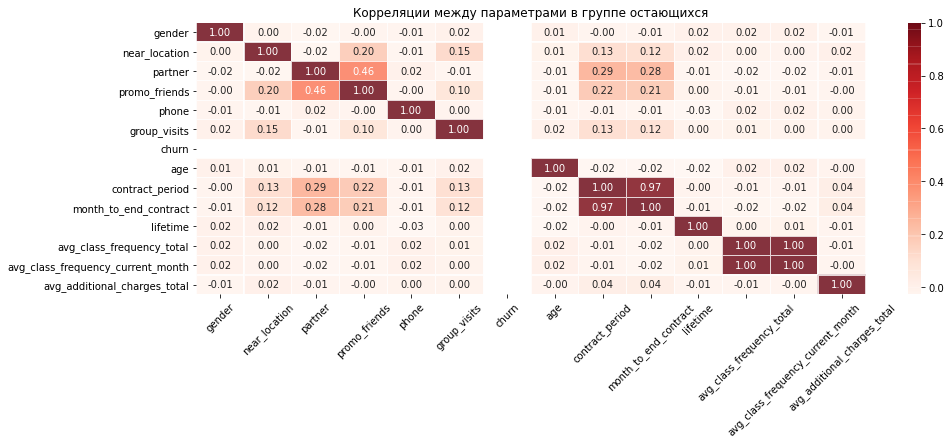

In [19]:
plt.figure(figsize=(15,5))
sns.heatmap(data=clients.query('churn == 0').corr(), annot=True, linewidths=0.1, fmt = '0.2f', alpha=0.8, cmap='Reds')
plt.title('Корреляции между параметрами в группе остающихся')
plt.xticks(rotation=45)
plt.show()

Результат вычисления корреляций одинаковый. Для группы остающихся работа в компании-партнера теснее связана с получением промо-кода, чем в групе ушедших (что в целом логично, компании-партнеры эти промо-коды и получают и коллеги зовут коллег). Неоднозначная связь есть и между параметрами "партнерство" и сроком дейтствия абонемента. Скорее всего сотрудники компаний-партнеров охотнее покупают более длительные абонементы.

By the way, казалось бы, что должна быть какая-то связь между количеством посещений фитнес-центра и выручкой от дополнительных услуг. Например, те кто ходит раз в 2 дня, тот тратит больше

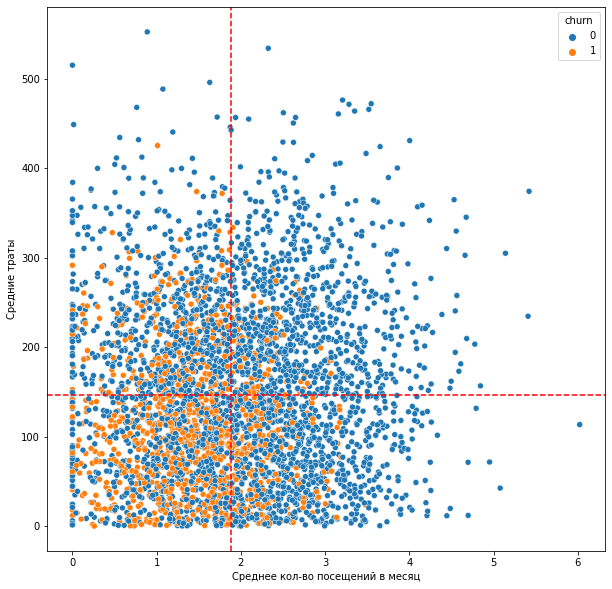

In [20]:
plt.figure(figsize=(10,10))
sns.scatterplot(data=clients, x='avg_class_frequency_total', y='avg_additional_charges_total', hue='churn')
plt.ylabel('Средние траты')
plt.xlabel('Cреднее кол-во посещений в месяц')
plt.axhline(y=clients['avg_additional_charges_total'].mean(), color='red', linestyle='--')
plt.axvline(x=clients['avg_class_frequency_total'].mean(), color='red', linestyle='--')
plt.show()

In [21]:
clients[['avg_class_frequency_total', 'avg_additional_charges_total']].query('avg_class_frequency_total > 3').corr()

,avg_class_frequency_total,avg_additional_charges_total
avg_class_frequency_total,1.000000,0.062666
avg_additional_charges_total,0.062666,1.000000


Как видно, корреляция между "количеством занятий в неделю" и "тратами на другие услуги" для "качков" еще меньше, чем в целом для всех. "Кулуьтуристы" скорее всего сами знают, что им нужно из дополнительных услуг и качалка для них это качалка, а не ресторан.
Также по графику видно, что некоторые клиенты, кто вообще не ходит в зал, потребляют дополнительные услуги достаточно активно. Кто-то не был ни разу, но "наел" на ~500 у.е. А самый "ультракачок" всего на ~110 у.е

**Вывод**

Таким образом, оттоку больше всего подвержены более молодые клиенты, которые работают не в компании-партнере или живут не в районе расположения фитнес-центра, не пришедшие по акции "приведи друга", купившие абонемент на месяц, но не сходившие в зал ни разу. *А потому что сидят за своими компуктерами и пандас ботают*

## Модель прогнозирования оттока клиентов

Как было указано выше, на отток никак не влияют пол и наличие телефона у клиента, поэтому при построении модели прогнозирования смело можем удалить данные параметры. Также в соответствии с гистограммами особых выбросов у колчиественных параметров нет.
Но для чистоты эксперимента, удалим из набора также некоторых "аномальных" пользователей, т.е. тех, кто ходит много, но тратит мало, или не ходит но при этом тратит

В ТЗ задании, который предоставил марктинговый отдел, предлагается использовать 2 модели - логистическую регрессию и случайный лес. Поэтому расширим перечень моделей для дополнительной проверки и повышеня качества прогнозирования, включим модель дерева принятия решений и Gradient Boosting. Предварительно подготовим данные.

Проверим также теорию. В дальнейшем моделировании будет проверены ключевые метрики моделей на обычной выборке и стандартизированной. В целом, стандратизация и удаление выбросов необходимо только для регрессионных моделей, в которых рассчитывается евклидово расстояние, классификационные модели основаны на деревьях решений, поэтому не сильно чувсвтительны к выбросам и ненормальным распределениям.

### Подготовка данных

На данном этапе проведем предварительную чистку, разделение датафрейма на признаки и целевую функцию, разделение на обучающую и валидационную выборки, стандартизацию, преобразование выборок и создание списка моделей

In [22]:
#создадим копию датафрейма для моделирования, удалим лишние параметры
model_df = clients.copy(deep=True)
model_df = model_df.drop(['gender', 'phone'], axis=1)

#удалим "аномалий" во всех количественных параметрах по 99 процентилю 
a = model_df.shape[0]
for col in qua_param_list:
    model_df = model_df[model_df[col] <= np.percentile(model_df[col], 99)]
b = model_df.shape[0]  

#объявим константу
RANDOM_STATE = 0

#подготовим данные для моделирования. разделим данные на признаки и целевую функцию
X = model_df.drop(['churn'], axis=1)
y  = model_df['churn']

# разделяим модель на обучающую и валидационную выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)

#стандартизируем данные, обучим StandartScaler  на обучающей выборке 
scaler = StandardScaler()
scaler.fit(X_train)

# преобразуеv обучающий и валидационные наборы данных
X_train_st = scaler.transform(X_train)
X_test_st = scaler.transform(X_test)



#создадим список моделей
models = [LogisticRegression(solver='liblinear', random_state=RANDOM_STATE), 
          DecisionTreeClassifier(random_state=RANDOM_STATE), 
          RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE), 
          GradientBoostingClassifier(n_estimators=100, random_state=RANDOM_STATE)]

#создадим список названий моделей
models_name = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'Gradient Boost']
models_name_st = ['Logistic Regression ST', 'Decision Tree ST', 'Random Forest ST', 'Gradient Boost ST']

In [23]:
print('Справочно. Для построения модели удалено', (a-b)/a * 100, '% аномальных клиентов')

Справочно. Для построения модели удалено 3.35 % аномальных клиентов


### Обучение моделей, расчет метрик

На данном этапе создадим функции обучения моделей и вывода основных метрик, применим её ко всем моделям 

In [24]:
def make_predictions(m, model_name, X_train, y_train, X_test, y_test):
    model = m
    #обучаем модель
    model.fit(X_train, y_train)
    #запускаем модель
    y_pred = model.predict(X_test)
    y_probas = model.predict_proba(X_test)
    #рассчитываем метрики
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_probas[:,1])
    #записываем результат в датафрейм
    model_metrics = pd.DataFrame({'Model': [model_name],
                                  'Accuracy': [accuracy],
                                  'Precision': [precision],
                                  'Recall': [recall],
                                  'F1': [f1],
                                  'ROC_AUC': [roc_auc]})
    #результат функции - датафрейм
    return model_metrics

In [25]:
#создадим путсой датафрейм
all_metrics = pd.DataFrame()
#пройдем циклом по моделям и их названиям 
for model, model_name in zip(models, models_name):
    model_metrics = make_predictions(model, model_name, X_train, y_train, X_test, y_test)
    all_metrics = pd.concat([all_metrics, model_metrics])
    

Проведем аналогичный расчет для стандартизованной выборки

In [26]:
#создадим путсой датафрейм
all_metrics_st = pd.DataFrame()
#пройдем циклом по моделям и их названиям 
for model, model_name in zip(models, models_name_st):
    model_metrics = make_predictions(model, model_name, X_train_st, y_train, X_test_st, y_test)
    all_metrics_st = pd.concat([all_metrics_st, model_metrics])

In [27]:
print('Метрики моделей на обычных данных')
display(all_metrics)
print('Метрики моделей на стандартизированных данных')
display(all_metrics_st)

Метрики моделей на обычных данных


,Model,Accuracy,Precision,Recall,F1,ROC_AUC
0,Logistic Regression,0.922481,0.876238,0.834906,0.855072,0.978211
0,Decision Tree,0.897933,0.821256,0.801887,0.811456,0.868025
0,Random Forest,0.925065,0.877451,0.844340,0.860577,0.972609
0,Gradient Boost,0.939276,0.910448,0.863208,0.886199,0.981921


Метрики моделей на стандартизированных данных


,Model,Accuracy,Precision,Recall,F1,ROC_AUC
0,Logistic Regression ST,0.923773,0.880597,0.834906,0.857143,0.978312
0,Decision Tree ST,0.897933,0.821256,0.801887,0.811456,0.868025
0,Random Forest ST,0.923773,0.876847,0.839623,0.857831,0.972617
0,Gradient Boost ST,0.939276,0.910448,0.863208,0.886199,0.981921


Как видим, стандартизация повлияла только на модель логистической регрессии. В самом деле, стандартизация важна для алгоритмов, в основе которых лежит расчет расстояния между координатами векторов. В нашем случае такая модель одна - логистическая регрессия. остальные алгоритмы в основе своей содержатдеревья решений. *Но знал бы прикуп, жил бы в Сочи*

Поэтому сравним модели в одной таблице, отбросим модели-аутсайдеры

### Выбор модели

In [28]:
all_metrics = all_metrics.append(all_metrics_st.head(1), ignore_index=True)

In [29]:
all_metrics.style.background_gradient(cmap='Greens', axis=0)

,Model,Accuracy,Precision,Recall,F1,ROC_AUC
0,Logistic Regression,0.922481,0.876238,0.834906,0.855072,0.978211
1,Decision Tree,0.897933,0.821256,0.801887,0.811456,0.868025
2,Random Forest,0.925065,0.877451,0.844340,0.860577,0.972609
3,Gradient Boost,0.939276,0.910448,0.863208,0.886199,0.981921
4,Logistic Regression ST,0.923773,0.880597,0.834906,0.857143,0.978312


Как видно логическая регрессия на стандартизированных данных работает лучше, чем логическая регрессия на обычных данных и случайный лес. Таким образом при выборе оптимальнйо модели для решения основной задачи исследования для модели предсказаний (основной ответ на посталенный вопрос исследования)необходимо выбрать модель логической регресси, которая работ работает немного лучше. В тоже время самые лучшие результаты прогнозирования целевой переменной поазывает модель Gradient Boosting.

Самые "плохие" результаты показывает модель дерева принятия решений

In [30]:
all_metrics_top = all_metrics.iloc[-2:]
all_metrics_top.style.background_gradient(cmap='Greens', axis=0)

,Model,Accuracy,Precision,Recall,F1,ROC_AUC
3,Gradient Boost,0.939276,0.910448,0.863208,0.886199,0.981921
4,Logistic Regression ST,0.923773,0.880597,0.834906,0.857143,0.978312


Т.о выбранные модели (логистическая регрессия и Gradient Boost):
- угадывают правильный ответ в  92-93% случаев;
- точность правильного ответа класса "1" составляет 86-89%
- обнаруживают 84% правильных ответа класса "1" 
- 85-86% - сводная точность правильного прогноза
- показывают качество классификации 97%

Посмотрим на коэффициенты модели логистической регрессии

In [31]:
# заново обучим модель
lr_model = LogisticRegression(solver='liblinear')
lr_model.fit(X_train_st, y_train)
y_pred = lr_model.predict(X_test)

# создадим датафрейм с именами признаков и их важностью и выведем его по убыванию важности
lr_coef_df = pd.DataFrame(data={'feature':X.columns, 'importance':lr_model.coef_[0]})
lr_coef_df.sort_values(by='importance', ascending=False)

,feature,importance
8,avg_class_frequency_total,3.004678
1,partner,-0.080244
0,near_location,-0.085914
2,promo_friends,-0.236213
3,group_visits,-0.393985
10,avg_additional_charges_total,-0.521649
6,month_to_end_contract,-0.522582
5,contract_period,-0.667006
4,age,-1.147472
7,lifetime,-3.530623


Заметим, что по идее 2 одинаковых параметра о количестве посещений центра в целом и за последний месяц имеют совершенно противоположный вклад (значимость) при определении ответа. ВЫсокий отрицательный коэффициент для avg_class_frequency_current_month	моет свидетельствовать о том, что данный параметр вносит значительный вклад при малых значениях. Т.е. в прошлый месяц клиент очень редко посещал центр => скорее всегов этом месяце будет 0 и вообще "отток".
Видно также, что некоторые параметры вносят малый вклад, например near_location и partner

Также можно оценить время обучения моделей и расчет параметров на коленке

In [32]:
def worktime(m, model_name, X_train, y_train, X_test, y_test):
    model = m
    #засекаем время начала обучения
    start_time = time.time()
    #обучаем модель
    model.fit(X_train, y_train)
    #запускаем модель
    y_pred = model.predict(X_test)
    y_probas = model.predict_proba(X_test)
    #засекаем время конца предсказаний
    end_time = time.time()
    work_time = end_time - start_time
    print("Время работы модели", model_name, "-", work_time, "секунд")

In [33]:
for model, model_name in zip(models, models_name):
    worktime(model, model_name, X_train, y_train, X_test, y_test)

Время работы модели Logistic Regression - 0.023013591766357422 секунд
Время работы модели Decision Tree - 0.018642902374267578 секунд
Время работы модели Random Forest - 0.44862985610961914 секунд
Время работы модели Gradient Boost - 0.5126068592071533 секунд


Т.е. в целом, если необходмо экономить ресурсы и предсказывать отток клиентов на выборке не 4000, а выборке размером с число Грэма, то целесообразнее использовать модель логической регрессии, которая работает в 24 раза быстрее. Но я думаю, что зависимость между объемом выборки и временем расчета не совсем линейная https://scikit-learn.ru/8-2-computational-performance/

## Кластеризация

### Обучение модели, кластеризация, описание кластеров

Воспользуемся алгоритмом, претставленным в теории

In [34]:
#удалим столбец 'churn'
X_cl = clients.copy(deep=True).drop(['churn'], axis = 1)

# стандартизируем данные
sc = StandardScaler()
x_sc = sc.fit_transform(X_cl)

#построим матрицу расстояний
linked = linkage(x_sc, method = 'ward')

# задаём модель k_means с числом кластеров 5 и фиксируем значение random_state
km = KMeans(n_clusters = 5, random_state = 0)
# прогнозируем кластеры для наблюдений (алгоритм присваивает им номера от 0 до 4)
labels = km.fit_predict(x_sc)

# сохраняем метки кластера в поле нашего датасета
clients['cluster_km'] = labels

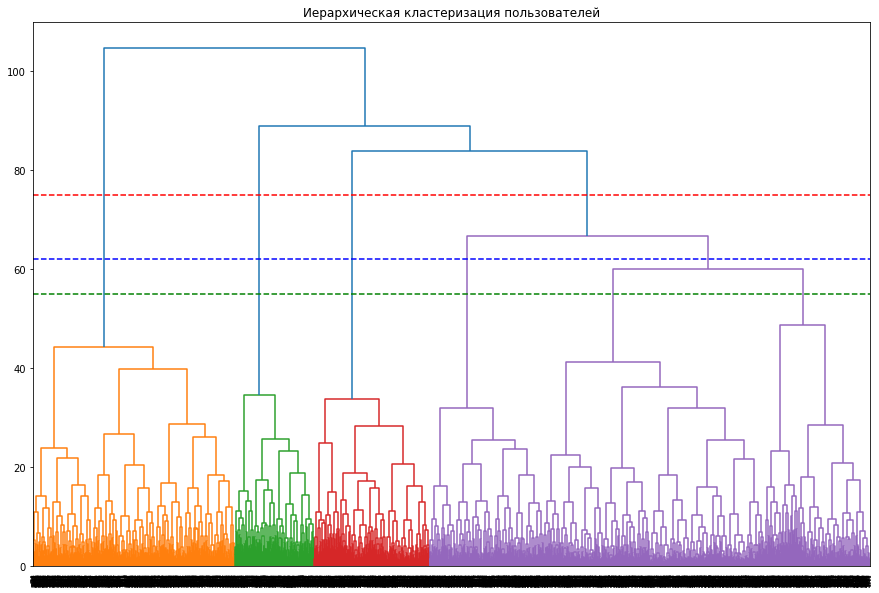

In [35]:
# Пострстроим дендрограмму:
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.axhline(y=75, color='red', linestyle='--')
plt.axhline(y=62, color='blue', linestyle='--')
plt.axhline(y=55, color='green', linestyle='--')
plt.title('Иерархическая кластеризация пользователей')
plt.show()

По дендрограмме видно, что в целом можно выделить 4-6 кластеров клиентов, в зависимости от расстояними между кластерами (красная, синяя и зеленая горизонтальные линии), поэтому выбор 5 кластеров для модели K-means вполне обоснован. При этом стоит отметить, что при таком количестве кластеров их размеры будут не одинаковые.

В тоже время существут способы аналитического (спасибо за сслыку на статью) определения необходимого количетсва кластеров по сумме квадратов расстояний от точек до центроидов кластеров, к которым они относятся.

Как видно на графике снизу $J(C_k)$ падает резко от 1 к 4, темп снижения от 4 к 5 и 6 заметно снижается, а от 7 к 9 практически прекращается, т.е. оптимальным кол-вом кластеров можно также назвать - 8 кластеров

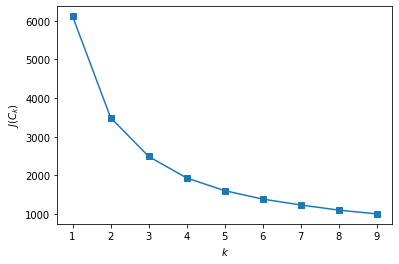

In [36]:
inertia = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=1).fit(clients)
    inertia.append(np.sqrt(kmeans.inertia_))

plt.plot(range(1, 10), inertia, marker='s');
plt.xlabel('$k$')
plt.ylabel('$J(C_k)$');

In [37]:
#определим размеры кластеров
clients.groupby('cluster_km')['age'].count()

cluster_km
0    1010
1     385
2     505
3    1262
4     838
Name: age, dtype: int64

In [38]:
#определим средние значения признаков для кластеров
clients.groupby('cluster_km').mean().T.style.background_gradient(cmap='Greens', axis=1)

cluster_km,0,1,2,3,4
gender,0.502970,0.522078,0.495050,0.485737,0.559666
near_location,0.959406,0.862338,0.000000,1.000000,0.976134
partner,0.783168,0.470130,0.463366,0.350238,0.356802
promo_friends,0.574257,0.306494,0.079208,0.240095,0.230310
phone,1.000000,0.000000,1.000000,1.000000,0.998807
group_visits,0.542574,0.425974,0.215842,0.341521,0.473747
churn,0.027723,0.267532,0.443564,0.514263,0.068019
age,29.982178,29.301299,28.477228,28.167987,30.125298
contract_period,10.889109,4.787013,2.352475,1.948494,2.669451
month_to_end_contract,9.954455,4.475325,2.198020,1.856577,2.459427


3) Точность кластеризации

In [39]:
# посчитаем метрику силуэта для нашей кластеризации
print('Silhouette_score: {:.2f}'.format(silhouette_score(x_sc, labels)))

Silhouette_score: 0.14


![фиаско](https://v1rt.ru/upload/medialibrary/aba/abae703344a3830fa0a794919febcf47.png)

Значение метрики оказалось не очень высоким, но плохой результат - тоже результат

**Выводы**
- Самыми многочисленными кластерами являются кластеры №№ 0 и 3. В кластере 0 одни из самых выскоких среднидних значений, в коастере 3 наоброт - одни из самых низких средних значений. Аналогично в кластере 0 в основном те, кто работает в компании -партнере, в кластере 3 таких всего 30%. Кластер 0 - один из самых платежеспособных, кластер 3 - нет.
- При этом кластер 0 - клиенты с самым низкой долей оттока, всего 2,7%, а вот клатер 3 - клиенты с самым высоким, практически каждый второй (51%) не вернется в фитнес-центр. Для данного кластера также характерны самые низкие значения среднего кол-ва посещений, лайфтайма, возраста, что вполне логично и данные результаты уже были получены при общем изучении "портрета" уходящих клиентов.
- Кластер 0 можно охареактризовать как ядро фитнеса - в среднем ходят не очень часто, но купили долгосрочне абонементы, находящиеся в начале своего культуристического пути (среднее кол-во месяцев до конца абонемента около 10) и тратят деньги.
- Кластер 4 - самые возрастные качки, ходят часто, тратят больше всех, живут/работают ближе всех, уходят очень редко
- Кластер 1 - малочисленные середнячки без телефона, купившие среднеосрочные абонементы
- Кластер 2 - живущие вдали от центра индивидуалы (не ходят на групповые занятия) попавшие в клуб без промо-кода, редко ходят в зал и мало тратят, склонны к оттоку

### Распределение признаков
 
 Для построения распределения признаков для кластеров также воспользуемся предложенным в теории алгоритмом
 
*Возможно, в теориии представлено не совсем корректное использование библиотеки seaborn, т.к. при использовании исходного кода из теории в результате возвращается ошибка о том, что в версии ХХХ надо напрямую указывать параметр data=, x=, y= *

Также необходимо помнить, что визуальное попраное сравнение признаков - 169 различных диаграммы. Попарно сравнивать категориальные признаки не имеет смысла, поэтому достаточно проверить количественные распределения и диаграммы плотностей

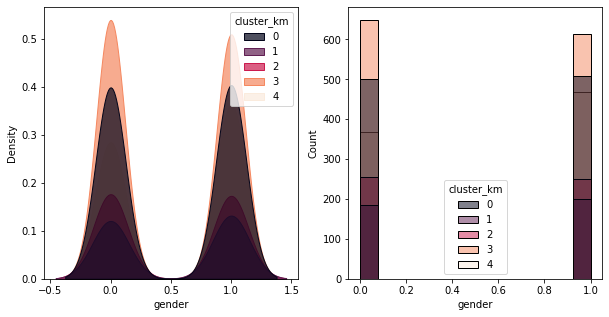

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


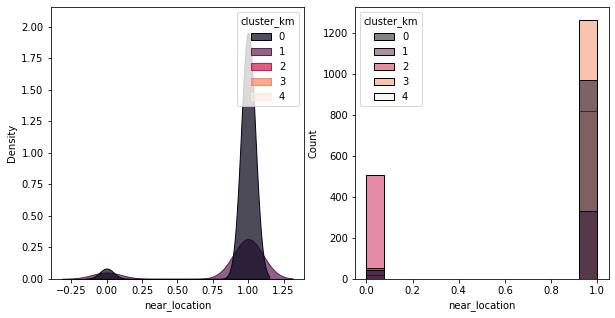

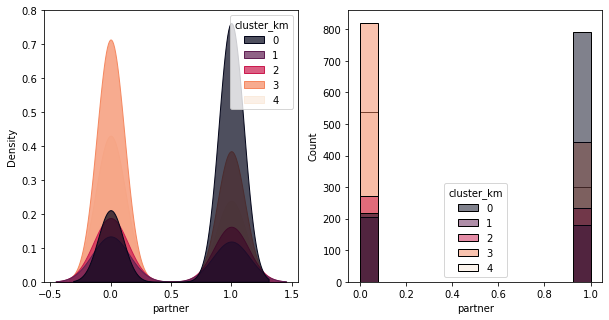

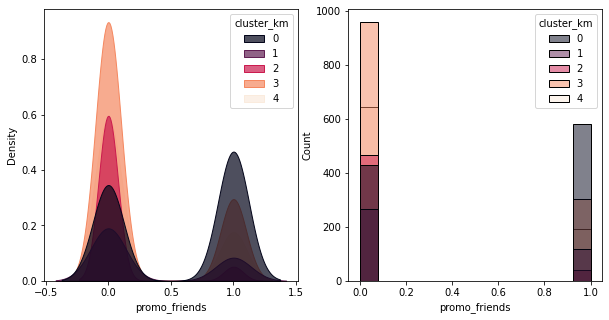

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


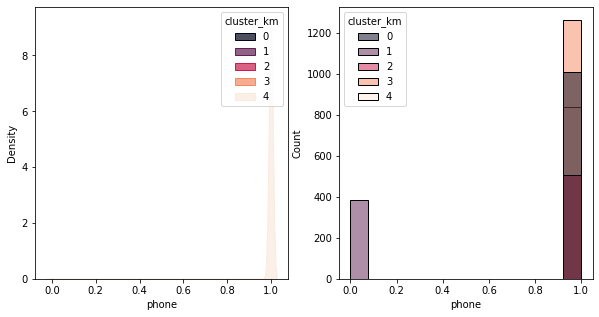

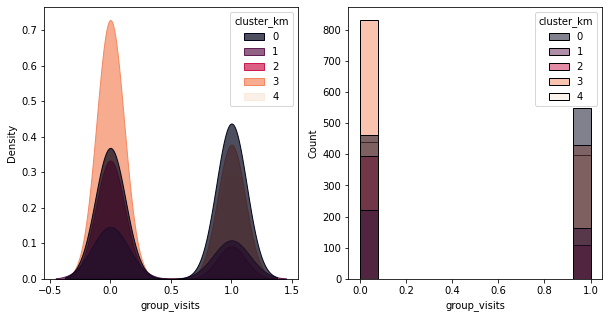

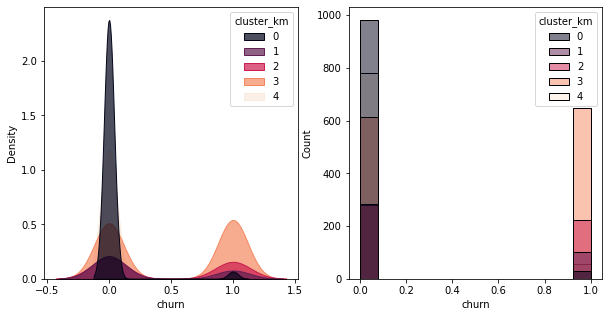

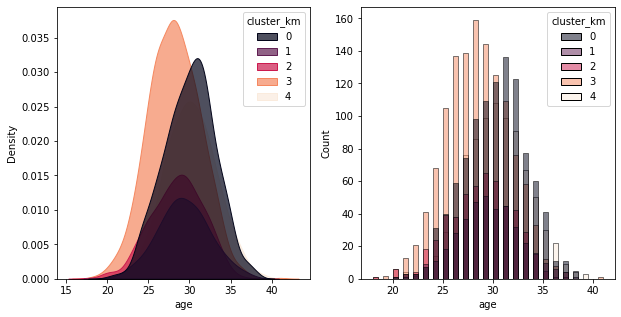

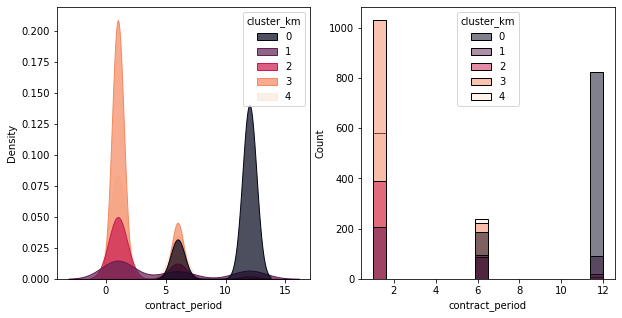

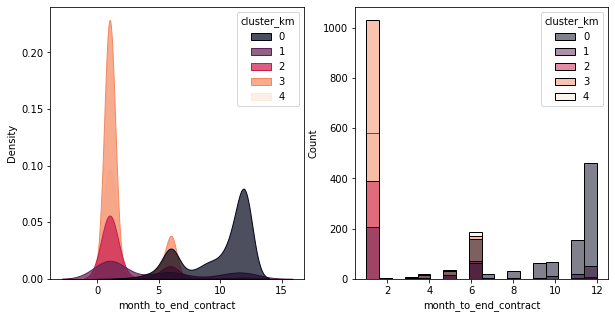

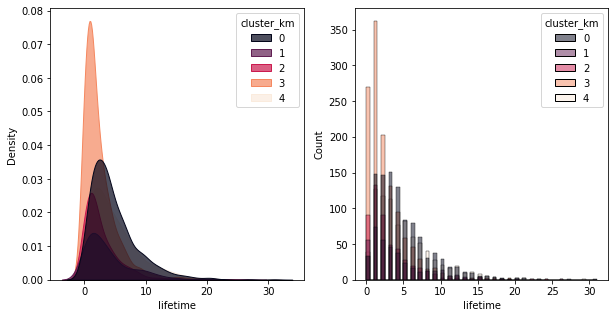

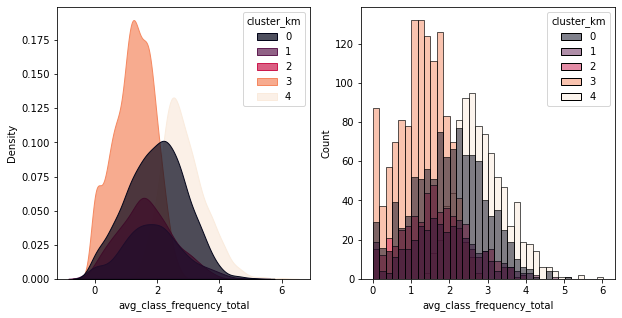

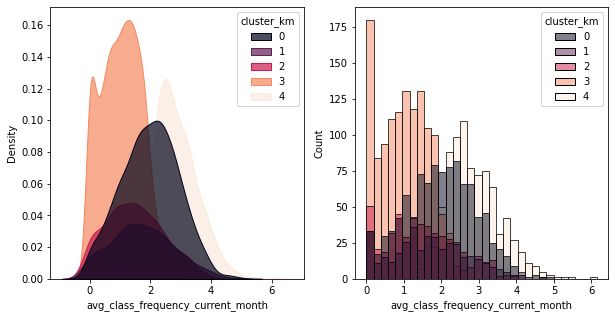

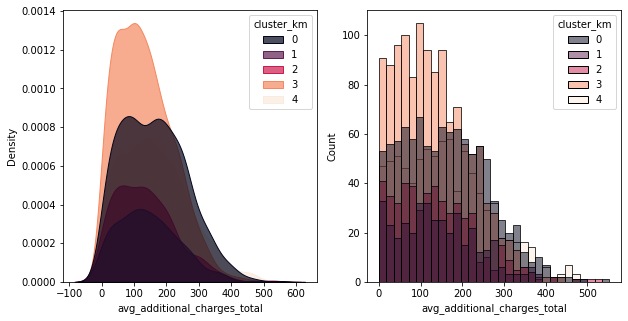

In [40]:
for feature in clients.drop(['cluster_km'], axis=1).columns:
    fig, ax = plt.subplots(figsize = (10, 5))
    sns.kdeplot(data=clients, x=feature, hue='cluster_km', fill=True, alpha=0.7, ax = plt.subplot(1,2,1), palette='rocket')
    sns.histplot(data=clients, x=feature, hue= 'cluster_km', ax = plt.subplot(1,2,2), palette='rocket')
    plt.show()

На основании полученных диаграмм можно подтвердить следующее, что кленты:
- из кластера 2 - далеко живут или работают
- из кластера 3:
1) больше молодежи
2) одномесячные абонементы
3) низкий лайфтайм
4) мало средненедельных посещений в целом и за последний месяц
5) основные претенденты на отток

Наиболее красивые картинки с расперделением кластеров конечно же получаются с помощью диаграмм рассеивания, но в нашем случае они наглядны только для количественных переменных. Зададим отдельный попарный список переменных и построим для них диаграммы рассеивания

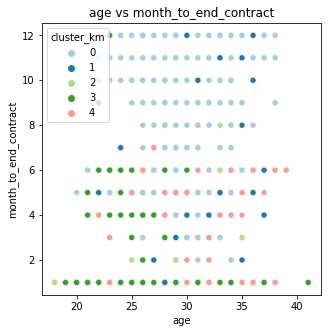

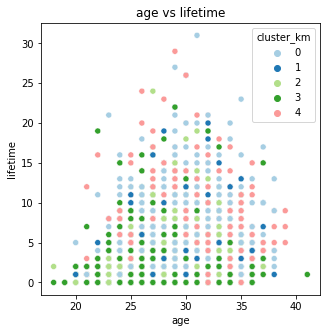

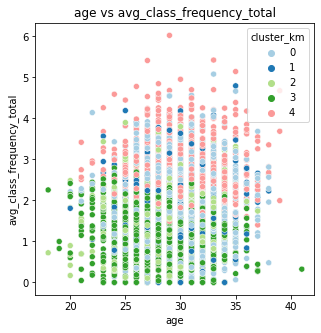

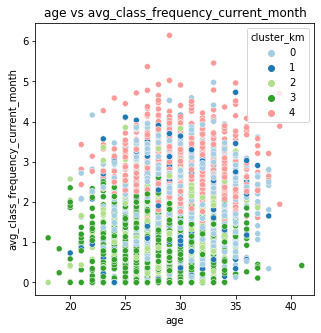

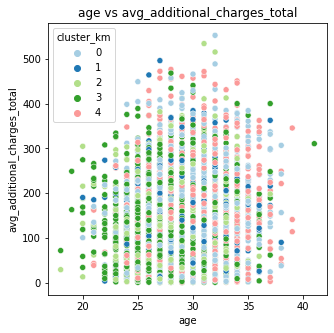

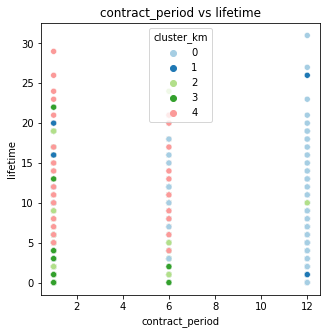

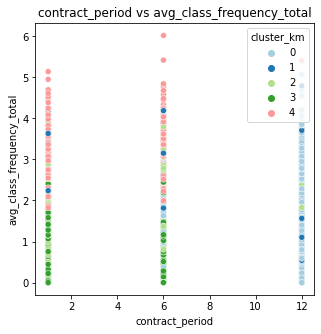

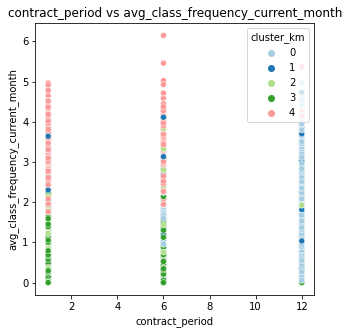

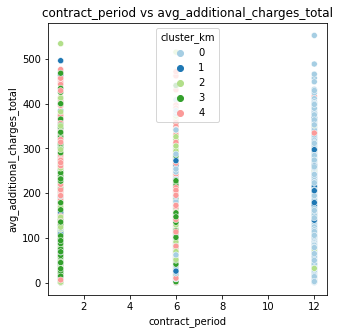

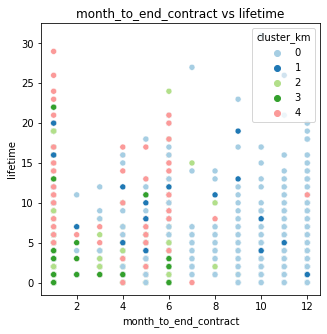

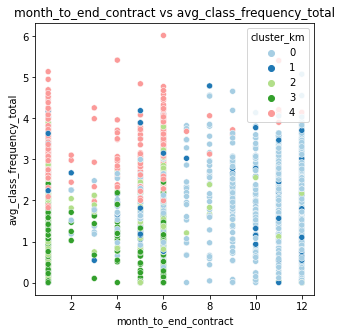

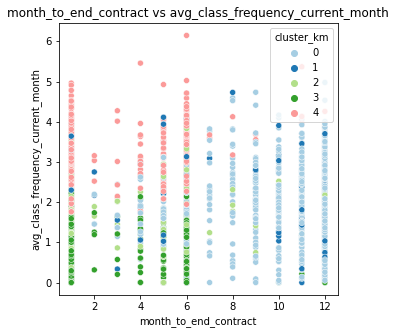

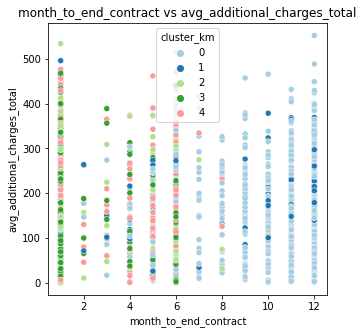

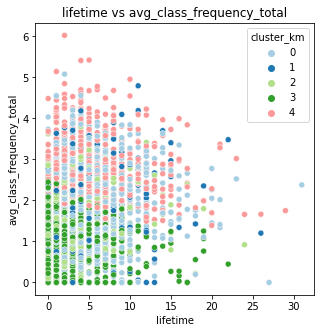

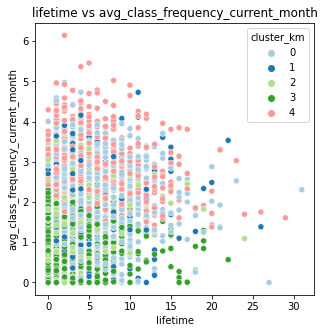

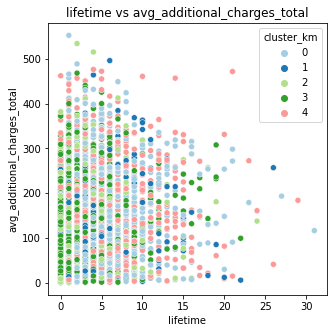

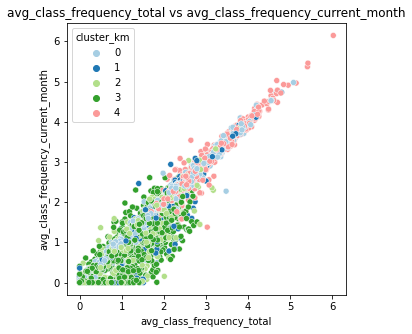

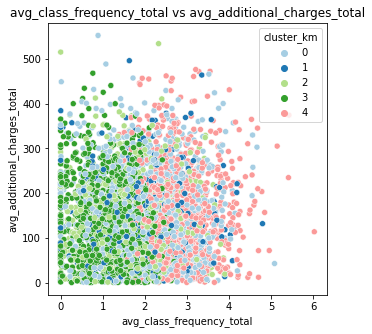

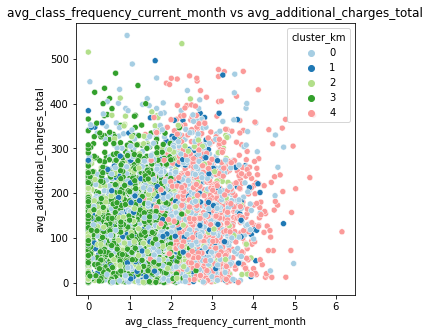

In [41]:
# определим функцию отрисовки графиков попарных признаков для кластеров
def show_clusters_on_plot(df, x_name, y_name, cluster_name):
    plt.figure(figsize=(5, 5))
    sns.scatterplot(data=df, x=df[x_name], y=df[y_name], hue=df[cluster_name], palette='Paired')
    plt.title('{} vs {}'.format(x_name, y_name))
    plt.show()

# получим весь попарный список
#col_pairs = list(itertools.combinations(clients.drop('cluster_km', axis=1).columns, 2))
#col_pairs

#задаим новый попраный список, полученный методом проб и ошибок
col_pairs = [('age', 'month_to_end_contract'),
 ('age', 'lifetime'),
 ('age', 'avg_class_frequency_total'),
 ('age', 'avg_class_frequency_current_month'),
 ('age', 'avg_additional_charges_total'),
 ('contract_period', 'lifetime'),
 ('contract_period', 'avg_class_frequency_total'),
 ('contract_period', 'avg_class_frequency_current_month'),
 ('contract_period', 'avg_additional_charges_total'),
 ('month_to_end_contract', 'lifetime'),
 ('month_to_end_contract', 'avg_class_frequency_total'),
 ('month_to_end_contract', 'avg_class_frequency_current_month'),
 ('month_to_end_contract', 'avg_additional_charges_total'),
 ('lifetime', 'avg_class_frequency_total'),
 ('lifetime', 'avg_class_frequency_current_month'),
 ('lifetime', 'avg_additional_charges_total'),
 ('avg_class_frequency_total', 'avg_class_frequency_current_month'),
 ('avg_class_frequency_total', 'avg_additional_charges_total'),
 ('avg_class_frequency_current_month', 'avg_additional_charges_total')]

#нарисуем диаграммы
for pair in col_pairs:
    show_clusters_on_plot(clients, pair[0], pair[1], 'cluster_km')

На основании данных диаграмм можно в дополнение заключить следующее:
- в кластере 0 больше долгосрочных абонементов и больше срок до конца абонементов (хотя такой вывод уже, кажется, был)
- в кластере 2 и 3 низкий лайфтайм  низкая посещаемость, в отличие от кластера 4, где посещаемость высокая
- чем дольше до конца срока абонемента, тем выше посещаемость

### Отток в разрезе кластеров

Хотя ранее это уже было предствалено в таблице, визуализируем

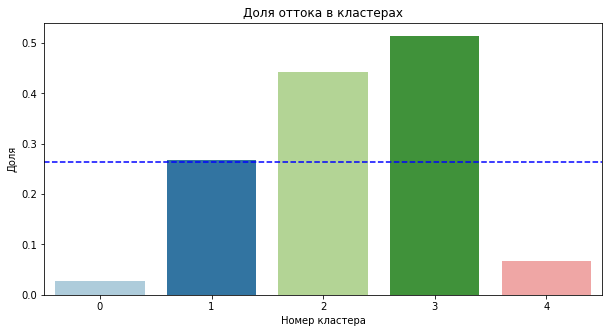

In [42]:
churn_by_cl = clients.groupby('cluster_km').agg({'churn':'mean'}).reset_index()
plt.figure(figsize=(10,5))
sns.barplot(data=churn_by_cl, x='cluster_km', y='churn', palette='Paired')
plt.axhline(y=churn_by_cl['churn'].mean(), color='blue', linestyle='--')
plt.title('Доля оттока в кластерах')
plt.xlabel('Номер кластера')
plt.ylabel('Доля')
plt.show()

Закрепим еще раз результат. Самые надежные кластеры - 0-й и 4-й, самые ненадежные и склонные к оттоку - 2-й и 3-й. 1-й кластер - пограничный, т.к. значение доли уходящих клиентов из этого кластера - "среднее по больнице"

### Вывод 

Была проведена оценка с помощью алгометрической иерархической кластеризации, а также расчета суммы квадратов расстояний, которые показали, что оптимальнео кол-во кластеров для данного набора данных составляет не менее 4 и не более 8. Было принято решение кластеризовать клиентов на 5 кластеров.

В результате была построена модель, которая показала "качество" кластеризации 0,14 или 14%. Не круто, но что есть, то есть.
Был также проведен анализ основных параметров полученных кластеров:

- Кластер 0 - ядро фитнес-центра. Самый многочисленный кластер, одни из самых высоких средних значений всех параметров. Клиенты из кластера живут близко к центру, работают в компании-партнере, плетежеспособны (покупают доп услуги), в среднем ходят не очень часто, но купили долгосрочне абонементы, находящиеся в начале своего культуристического пути. В данном кластере наимегьший отток
- Кластер 1 - малочисленные середнячки без телефона, купившие среднеосрочные абонементы. В среднем вероятность оттока клиентов из данного кластера равна 30%
- Кластер 2 - живущие вдали от центра индивидуалы (не ходят на групповые занятия) попавшие в клуб без промо-кода, редко ходят в зал и мало тратят, склонны к оттоку
- Кластер 3 - самые низкие значения среднего кол-ва посещений, лайфтайма, возраста, самый высокий отток - группа "риска"
- Кластер 4 - самые возрастные качки, ходят часто, тратят больше всех, живут/работают ближе всех, уходят очень редко


## Заключение и рекомендации

*Если быть МЛ-роботом, то можно в первую очередь заключить следующее (ха-ха):выборка смещена в сторону тех, кто живет рядом с фитнес-центром и имеет телефон (указал телефон в анкете)*

В соответствии с техническим заданием был проведен анализ и опробованы модели прогнозирования оттока клиентов нашего любимого фитнес-центра, а также проведена кластеризация клиентов. В результате были отобраны 2 модели прогнозирования, показавшие наилучшие результаты обучения и предсказания - логистическая регрессия и градиентный бустинг для решения задач классификации.
 
1) Выявлено, что если клиент:
- живет/работает далеко от клуба 
- менее 25 лет 
- купил абонемент на 1 месяц
- до конца срока действия абонемента осталось 1 и менее месяцев
- время с момента первого обращения в фитнес-центр 1 месяц и меньше
- количество посещений фитнес-центра в месяц ниже среднего 
- расходы на доп. услуги ниже среднего
*скорее всего не вернется обратно**

Т.е. оттоку больше всего подвержены более молодые клиенты, которые работают не в компании-партнере или живут не в районе расположения фитнес-центра, не пришедшие по акции "приведи друга", купившие абонемент на месяц, но не сходившие в зал ни разу.

2) В результате кластерзации выявлено 5 кластеров клиентов, которых условно можно разделить на группы:
- наименьший отток 
    - ядерные культуристы - живут близко к центру, работают в компании-партнере, плетежеспособны (покупают доп услуги), в среднем ходят не очень часто, но купили долгосрочне абонементы, находящиеся в начале своего культуристического пути
    - качки - самые возрастные качки, ходят часто, тратят больше всех, живут/работают ближе всех, уходят очень редко
- средний отток
    - малочисленные середнячки без телефона, купившие среднеосрочные абонементы
- наибольший отток:
    - живущие вдали от центра индивидуалы (не ходят на групповые занятия) попавшие в клуб без промо-кода, редко ходят в зал и мало тратят
    - самые молодые, с низким количествоим, лайфтайма - группа "риска"

3) Рекомендации общие:
- увеличить срок абонемента и сделать его более дискретным вместо 1м, 6м, 12м 
- организовать кампанию по привлечению новых клиентов за счет присоединения новых компаний-партнеров
- расширить сеть
- в анкете поле с указанием номера телефона сделать обязательным для заполнения (влияет на кластеризацию)
- придумать стимулирующие методы для привлечения клиентов на групповые занятия
- расширить ассортимент дополнительных услуг
- рассылать промо-код на скидку 
- превратить "качков" в инфлюенсеров, которые на своем опыте покажут, что это круто ходить в качалку больше 2-х раз в неделю
- продумать внедрение регрессивной шкалы стоимости абонементов, когда выгоднее покупать более долгосрочный абонемент (но что нпо этому поводу скажет бухгалтерия)


*Гипотеза*: у тех клиентов, у которых не указан телефон, очень даже может быть нет телефона. Поэтому предлагается реализация кампании "Абонемент-смартфон" - каждому кто купит абонемент, предоставляется смартфон в пользовнаие на период действия абонемента. Ну, мало ли...
    
